<a href="https://colab.research.google.com/github/sarthakkaushik/Cdiscount-Image-Classification/blob/main/Cdiscount_project_RESNET101_V3_SK_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Setup

In [ ]:
# Code to mount google drive in case you are loading the data from your google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
# Are we using a GPU? (if not & you're using Google Colab, go to Runtime -> Change Runtime Type -> Harware Accelerator: GPU )
!nvidia-smi

Wed Jan 26 18:50:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    39W / 300W |   2517MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
data_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount'

In [ ]:
import os 
data_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount'
os.chdir(data_path)
print(os.getcwd())

/gdrive/MyDrive/UOH Assignment Dataset/cdiscount


In [ ]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct
import random

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../cdiscount"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

categories.csv
category_names.csv
CheckPoints
file.h5
helper.py
helper.py.1
helper.py.10
helper.py.11
helper.py.2
helper.py.3
helper.py.4
helper.py.5
helper.py.6
helper.py.7
helper.py.8
helper.py.9
output_data
__pycache__
sample_submission.csv
Tensorboard
test.bson
train.bson
train_example.bson
train_images.csv
training_logs
train_offsets.csv
train_TFrecords_TEST.tfrecords
train_TFrecords.tfrecords
val_images.csv



#Setup Weights and Biases

In [ ]:
# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [ ]:
%%capture
!pip install wandb

Import W&b login

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#Importing Data Goole Drive

In [ ]:
data_dir = "../cdiscount/"

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

# train_bson_path = os.path.join(data_dir, "train_example.bson")
# num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

# Create lookup tables

In [ ]:
#The generator uses several lookup tables that describe the layout of the BSON file, which products and images are part of the training/validation sets, and so on.

#You only need to generate these tables once, as they get saved to CSV files.

#Lookup table for categories
categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

# categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [ ]:
#Create dictionaries for quick lookup of category_id to category_idx mapping.
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    i=0
    for ir in categories_df.itertuples():
            
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
      
    return cat2idx, idx2cat

In [ ]:

cat2idx, idx2cat = make_category_tables()

In [ ]:
# Test if it works:
cat2idx[1000012755], idx2cat[4]

(4, 1000012755)

#One time File Creation

In [ ]:
#this takes a few minutes to execute, but we only have to do it once (we'll save the table to a CSV file afterwards).
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length

            item = bson.BSON.decode(item_data)
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [ ]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

In [ ]:
train_offsets_df.columns

In [ ]:
train_offsets_df.head()

In [ ]:
train_offsets_df['category_id'].value_counts()

In [ ]:
train_offsets_df['num_imgs'].value_counts()

In [ ]:
train_offsets_df.to_csv("train_offsets.csv")

##Create a random train/validation split
We split on products, not on individual images. Since some of the categories only have a few products, we do the split separately for each category.

This creates two new tables, one for the training images and one for the validation images. There is a row for every single image, so if a product has more than one image it occurs more than once in the table.

In [ ]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)   
    return train_df, val_df

In [ ]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.2, 
                                              drop_percentage=0.9)

7069896it [00:09, 735466.32it/s]
  0%|          | 5596/7069896 [00:01<28:04, 4194.67it/s]


KeyboardInterrupt: ignored

In [ ]:
train_images_df.head()

In [ ]:
val_images_df.head()

In [ ]:
print("Number of training images:", len(train_images_df))
print("Number of validation images:", len(val_images_df))
print("Total images:", len(train_images_df) + len(val_images_df))

In [ ]:
len(train_images_df["category_idx"].unique()), len(val_images_df["category_idx"].unique())

In [ ]:
train_images_df.to_csv("train_images.csv")
val_images_df.to_csv("val_images.csv")

##Part 2: The generator

In [ ]:
#First load the lookup tables from the CSV files (you don't need to do this if you just did all the steps from part 1).

categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images.csv", index_col=0)
val_images_df = pd.read_csv("val_images.csv", index_col=0)


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from PIL import Image

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), 
                 with_labels=True, batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)
        self.lock = lock

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Load the image.
            #img = load_img(io.BytesIO(bson_img), target_size=self.target_size)
            #print(type(bson_img))
            #img  = load_img(bson_img, target_size =self.target_size)
            # Converting Keras Preprocessing Image load to Pillow Based loading
            # After loading convert to RGB optional as PIL loads in default RGGB
            # And resize is a necessary operation - to self.target_size
            
            img = Image.open(io.BytesIO(bson_img))
            img = img.convert('RGB')
            img = img.resize(self.target_size, Image.NEAREST)
            # Preprocess the image.
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                batch_y[i, image_row["category_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        return self._get_batches_of_transformed_samples(index_array)

In [ ]:
train_bson_file = open(train_bson_path, "rb")

#Create a generator for training and a generator for validation.

In [ ]:
#Because the training and validation generators read from the same BSON file, they need to use the same lock to protect it.
import threading
lock = threading.Lock()

In [ ]:
num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 128

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, lock,
                       batch_size=batch_size, shuffle=True)

Found 989921 images belonging to 5270 classes.
Found 242366 images belonging to 5270 classes.


In [ ]:
next(train_gen)  # warm-up

%time bx, by = next(train_gen)

CPU times: user 861 ms, sys: 111 ms, total: 971 ms
Wall time: 2min 29s


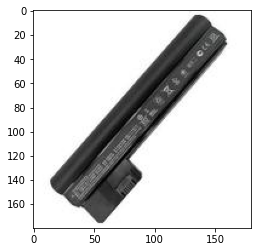

In [ ]:
plt.imshow(bx[-1].astype(np.uint8))

category_level1                            INFORMATIQUE
category_level2              CONNECTIQUE - ALIMENTATION
category_level3    BATTERIE D'ALIMENTATION INFORMATIQUE
category_idx                                       2522
Name: 1000004085, dtype: object
category_level1              LIBRAIRIE
category_level2               MEDECINE
category_level3    OUVRAGE PATHOLOGIE 
category_idx                      3353
Name: 1000014233, dtype: object


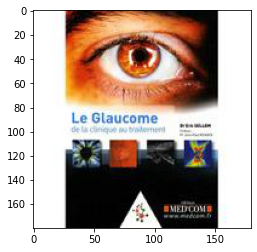

In [ ]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
print(categories_df.loc[cat_id])

bx, by = next(val_gen)

plt.imshow(bx[-1].astype(np.uint8))

cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
print(categories_df.loc[cat_id])

In [ ]:
#Importing packages
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization,Dense, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# Get helper_functions.py script from course GitHub
# !wget https://raw.githubusercontent.com/sarthakkaushik/Cdiscount-Image-Classification/main/helper.py

# Import helper functions we're going to use
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

#Turning On Mixed Precesion


In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

#Model-1-ResNet52

Callbacks

In [ ]:
#Define callbacks

import datetime


dir_name = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard'


#Tensorboard Callback
def create_tensorboard_callback(experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Setup checkpoint path
checkpoint_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/ResNet101/checkpoint.ckpt' # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch",# save every epoch
                                                         monitor="val_loss", 
                                                         verbose=1)


# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training



# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)


#Step Decay

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))


class StepDecay(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=2):
      # store the base initial learning rate, drop factor, and
      # epochs to drop every
      self.initAlpha = initAlpha
      self.factor = factor
      self.dropEvery = dropEvery
  def __call__(self, epoch):
      # compute the learning rate for the current epoch
      exp = np.floor((1 + epoch) / self.dropEvery)
      alpha = self.initAlpha * (self.factor ** exp)
      # return the learning rate
      return float(alpha)

optimizer = tf.keras.optimizers.Adam(learning_rate=StepDecay(initAlpha=1e-1, factor=0.25, dropEvery=2))






Creating Weghts & Biases Logger

In [ ]:
# Initialize wandb with your project name
run = wandb.init(project='CDiscount-RESNET101',
                 config={  # and include hyperparameters and metadata
                     
                     "epochs": 8,
                     "batch_size": 128,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "Resnet-101",
                     "dataset": "Cdiscount"
                 })
config = wandb.config  # We'll use this to configure our experiment

In [ ]:
class LRLogger(tf.keras.callbacks.Callback):
    def __init__(self, optimizer):
      super(LRLogger, self).__init__()
      self.optimizer = optimizer

    def on_epoch_end(self, epoch, logs):
      lr = self.optimizer.learning_rate(epoch)
      wandb.log({"lr": lr}, commit=False)

Modelling

In [ ]:


tf.keras.backend.clear_session()

###------------------------Base Model----------------------------------###

base_model_RestNet101=tf.keras.applications.ResNet101(include_top=False,weights="imagenet",input_shape=None,)
base_model_RestNet101.trainable =False

#Setup Model architecture

inputs= layers.Input(shape=(180,180,3), name="input_layers",dtype=tf.float16) # updating dtype to float16 to handle mixed precesion
x = preprocessing.Rescaling(1./255)(inputs) # Resent do not scale the image hence need to do manually
x=base_model_RestNet101(x,training=False)
x=layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D_layers")(x)
outputs=layers.Dense(num_classes, activation="softmax", dtype=tf.float32,name="output_layers_float_32")(x) # Converting back to float 32 from our mixed precesion
model_1=tf.keras.Model(inputs,outputs)






#Getting the summary of the model we created
model_1.summary()


#Defining f1 score

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))





#Compile the model
model_1.compile(optimizer='Adam',  #optimizer we defined above 
                loss='categorical_crossentropy',  # optimizer="adam",            
              
              metrics=['accuracy',precision_m,recall_m,f1_m]
              )



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 resnet101 (Functional)      (None, None, None, 2048)  42658176  
                                                                 
 GlobalAveragePooling2D_laye  (None, 2048)             0         
 rs (GlobalAveragePooling2D)                                     
                                                                 
 output_layers_float_32 (Den  (None, 5270)             10798230  
 se)                                                             
                                                                 
Total params: 53,456,406
Trainable params: 10,798,230
Non-tra

In [ ]:
temp=model_1.layers[3]
temp

In [ ]:
#Checking layer dtype policies (are we using mixed precision?)

# Check the dtype_policy attributes of layers in our model
for layer in model_1.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layers True float16 <Policy "float16">
rescaling True float32 <Policy "mixed_float16">
resnet101 False float32 <Policy "mixed_float16">
GlobalAveragePooling2D_layers True float32 <Policy "mixed_float16">
output_layers_float_32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model_1.layers[2].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
conv1_pad False float32 <Policy "mixed_float16">
conv1_conv False float32 <Policy "mixed_float16">
conv1_bn False float32 <Policy "mixed_float16">
conv1_relu False float32 <Policy "mixed_float16">
pool1_pad False float32 <Policy "mixed_float16">
pool1_pool False float32 <Policy "mixed_float16">
conv2_block1_1_conv False float32 <Policy "mixed_float16">
conv2_block1_1_bn False float32 <Policy "mixed_float16">
conv2_block1_1_relu False float32 <Policy "mixed_float16">
conv2_block1_2_conv False float32 <Policy "mixed_float16">
conv2_block1_2_bn False float32 <Policy "mixed_float16">
conv2_block1_2_relu False float32 <Policy "mixed_float16">
conv2_block1_0_conv False float32 <Policy "mixed_float16">
conv2_block1_3_conv False float32 <Policy "mixed_float16">
conv2_block1_0_bn False float32 <Policy "mixed_float16">
conv2_block1_3_bn False float32 <Policy "mixed_float16">
conv2_block1_add False float32 <Policy "mixed_float16">
conv2_block1_out False fl

In [ ]:
#Fit the model

history_1=model_1.fit(
    train_gen,
    # steps_per_epoch=np.ceil(float(num_train_images) // float(batch_size)),   #num_train_images // batch_size,
    epochs = 8,
    validation_data = val_gen,
    # validation_steps=np.ceil(0.25*(float(num_train_images) // float(batch_size))),  #25% of #num_val_images // batch_size,
    # callbacks=[checkpoint_callback,
    #            WandbCallback(),# using WandbCallback to log default metrics.
    #           LRLogger(optimizer)], # using callback to log learning rate.
    callbacks=[checkpoint_callback,create_tensorboard_callback("RESNET101"),reduce_lr,early_stopping],
               
   verbose=2                
    
    )
run.finish()

Saving TensorBoard log files to: /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard/RESNET101/20220126-193209


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/8

Epoch 00001: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/ResNet101/checkpoint.ckpt
7734/7734 - 4696s - loss: 6.2692 - accuracy: 0.1104 - precision_m: 0.6277 - recall_m: 0.0156 - f1_m: 0.0302 - val_loss: 5.8774 - val_accuracy: 0.1433 - val_precision_m: 0.8447 - val_recall_m: 0.0341 - val_f1_m: 0.0650 - lr: 0.0010 - 4696s/epoch - 607ms/step
Epoch 2/8

Epoch 00002: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/ResNet101/checkpoint.ckpt
7734/7734 - 3475s - loss: 5.7848 - accuracy: 0.1584 - precision_m: 0.8780 - recall_m: 0.0439 - f1_m: 0.0830 - val_loss: 5.6547 - val_accuracy: 0.1719 - val_precision_m: 0.8898 - val_recall_m: 0.0530 - val_f1_m: 0.0994 - lr: 0.0010 - 3475s/epoch - 449ms/step
Epoch 3/8

Epoch 00003: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/ResNet101/checkpoint.ckpt
7734/7734 - 3482s - loss: 5.5804 - accuracy: 0.1783 - precision_m: 0.8841 - recall_m: 0.0623 - f1_m: 0.

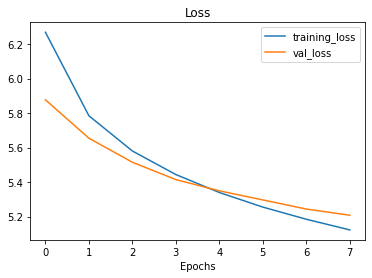

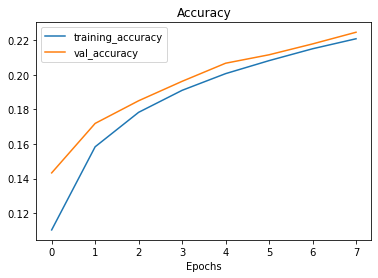

In [ ]:
# Plot model loss curves
plot_loss_curves(history_1)

#Model-2

In [ ]:


tf.keras.backend.clear_session()

###------------------------Base Model----------------------------------###

base_model_Xception=tf.keras.applications.Xception(include_top=False,weights="imagenet",input_shape=None,)
base_model_Xception.trainable =False

#Setup Model architecture

inputs= layers.Input(shape=(180,180,3), name="input_layers",dtype=tf.float16) # updating dtype to float16 to handle mixed precesion
x=tf.keras.applications.xception.preprocess_input(inputs, data_format=None)
# x = preprocessing.Rescaling(1./255)(inputs) # Resent do not scale the image hence need to do manually
x=base_model_Xception(x,training=False)
x=layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D_layers")(x)
outputs=layers.Dense(num_classes, activation="softmax", dtype=tf.float32,name="output_layers_float_32")(x) # Converting back to float 32 from our mixed precesion
model_2=tf.keras.Model(inputs,outputs)






#Getting the summary of the model we created
model_2.summary()



#Compile the model
model_2.compile(optimizer='Adam',  #optimizer we defined above 
                loss='categorical_crossentropy',  # optimizer="adam",            
              
              metrics=['accuracy',precision_m,recall_m,f1_m]
              )



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 GlobalAveragePooling2D_laye  (None, 2048)             0         
 rs (GlobalAveragePooling2D)                                     
                                                             

In [ ]:
#Fit the model

history_2=model_2.fit(
    train_gen,
    epochs = 8,
    validation_data = val_gen,
    callbacks=[checkpoint_callback,create_tensorboard_callback("Xception"),reduce_lr,early_stopping],
               
   verbose=2                
    
    )
run.finish()

Saving TensorBoard log files to: /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard/Xception/20220127-035021


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/8

Epoch 00001: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/ResNet101/checkpoint.ckpt
7734/7734 - 3531s - loss: 3.5419 - accuracy: 0.4071 - precision_m: 0.7627 - recall_m: 0.2806 - f1_m: 0.4059 - val_loss: 3.2879 - val_accuracy: 0.4430 - val_precision_m: 0.7632 - val_recall_m: 0.3291 - val_f1_m: 0.4590 - lr: 0.0010 - 3531s/epoch - 457ms/step
Epoch 2/8

Epoch 00002: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/ResNet101/checkpoint.ckpt
7734/7734 - 3472s - loss: 2.4765 - accuracy: 0.5032 - precision_m: 0.7952 - recall_m: 0.3814 - f1_m: 0.5146 - val_loss: 3.3215 - val_accuracy: 0.4550 - val_precision_m: 0.7413 - val_recall_m: 0.3582 - val_f1_m: 0.4821 - lr: 0.0010 - 3472s/epoch - 449ms/step
Epoch 3/8

Epoch 00003: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/ResNet101/checkpoint.ckpt

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
7734/7734 - 3509s - l

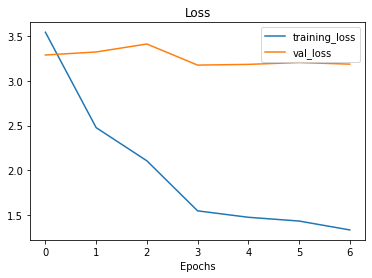

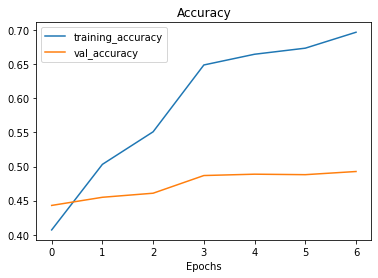

In [108]:
# Plot model loss curves
plot_loss_curves(history_2)

#Model-3

In [ ]:
#Define callbacks

import datetime


dir_name = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard'
def create_tensorboard_callback(experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Setup checkpoint path
checkpoint_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet/checkpoint.ckpt' # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)




###------------------------Base Model----------------------------------

base_model=tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable =False

#Setup Model architecture

inputs= layers.Input(shape=(180,180,3), name="input_layers")
x=base_model(inputs,training=False)
print(f"Shape after base_model: {x.shape}")
x=layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D_layers")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")
outputs=layers.Dense(num_classes, activation="softmax", name="output_layers")(x)
model=tf.keras.Model(inputs,outputs)


#Getting the summary of the model we created
model.summary()

#Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

#Fit the model

history_3=model.fit(
    train_gen,
    # steps_per_epoch=np.ceil(float(num_train_images) // float(batch_size)),   #num_train_images // batch_size,
    epochs = 3,
    validation_data = val_gen,
    # validation_steps=np.ceil(0.25*(float(num_train_images) // float(batch_size))),  #25% of #num_val_images // batch_size,
    callbacks=[checkpoint_callback,create_tensorboard_callback("TranferLearning_EfficientNetB7")],    
    verbose=2                
    # workers = 4
    )




Shape after base_model: (None, 5, 5, 2560)
After GlobalAveragePooling2D(): (None, 2560)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 GlobalAveragePooling2D_laye  (None, 2560)             0         
 rs (GlobalAveragePooling2D)                                     
                                                                 
 output_layers (Dense)       (None, 5270)              13496470  
                                                                 
Total params: 77,594,157
Trainable params: 13,496,470
Non-trainable params: 64,097,687
_________________________________________________________________
Saving TensorBoard

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3

Epoch 00001: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet/checkpoint.ckpt
7734/7734 - 5758s - loss: 3.3011 - accuracy: 0.4234 - val_loss: 3.0107 - val_accuracy: 0.4606 - 5758s/epoch - 744ms/step
Epoch 2/3

Epoch 00002: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet/checkpoint.ckpt
7734/7734 - 4831s - loss: 2.4507 - accuracy: 0.5101 - val_loss: 2.9550 - val_accuracy: 0.4768 - 4831s/epoch - 625ms/step
Epoch 3/3

Epoch 00003: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet/checkpoint.ckpt
7734/7734 - 4832s - loss: 2.1231 - accuracy: 0.5532 - val_loss: 2.9524 - val_accuracy: 0.4858 - 4832s/epoch - 625ms/step


In [ ]:
# Evaluate on the test data
results_histor_3 = model.evaluate(val_gen)
results_histor_3

1894/1894 [==============================] - 958s 506ms/step - loss: 2.9524 - accuracy: 0.4858


[2.9524197578430176, 0.48579421639442444]

In [ ]:
results_histor_3

[3.015165328979492, 0.496476411819458]

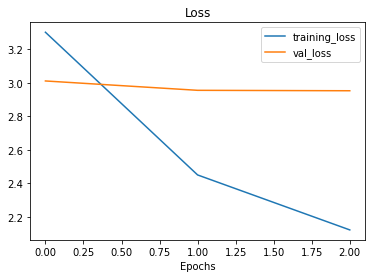

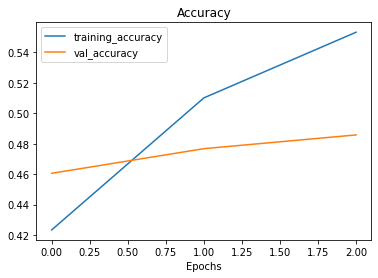

In [ ]:
# Plot model loss curves
plot_loss_curves(history_3)

#Model3- FIne Tuning 

In [ ]:
# Load in saved model weights and evaluate model
model.load_weights(checkpoint_path)
# loaded_weights_model_results = model.evaluate(val_gen)

NameError: ignored

In [ ]:
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_histor_3), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Layers in loaded model
model.layers

In [ ]:
for layer in model.layers:
  print(layer.trainable)

True
True
True
True


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 GlobalAveragePooling2D_laye  (None, 2560)             0         
 rs (GlobalAveragePooling2D)                                     
                                                                 
 output_layers (Dense)       (None, 5270)              13496470  
                                                                 
Total params: 77,594,157
Trainable params: 18,831,670
Non-trainable params: 58,762,487
_________________________________________________________________


In [ ]:
print(len(model.layers[1].trainable_variables))

10


In [ ]:
# How many layers are trainable in our base model?
print(len(model.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB7 layer (the base model)
print(len(base_model.trainable_variables))

0
0


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block1c_dwconv False
30 block1c_bn False
31 block1c_activation False
32 block1c_se_squeeze False
33 block1c_se_reshape False
34 block1c_se_reduce False
35 block1c_se_expand False
36 block1c_se_excite False
37 block1c_project_conv False
38 block1c_project_bn False
39 block1c_drop Fal

In [ ]:
base_model.trainable = True

# Freeze all layers except for the last 12
for layer in base_model.layers[:-12]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block1c_dwconv False
30 block1c_bn False
31 block1c_activation False
32 block1c_se_squeeze False
33 block1c_se_reshape False
34 block1c_se_reduce False
35 block1c_se_expand False
36 block1c_se_excite False
37 block1c_project_conv False
38 block1c_project_bn False
39 block1c_drop Fal

In [ ]:
#No of trainable layers
print(len(model.trainable_variables))

12


In [ ]:
#Define callbacks

import datetime


dir_name = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard'
def create_tensorboard_callback(experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Setup checkpoint path
checkpoint_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet_FineTune/checkpoint.ckpt' # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)


# Fine tune for another 5 epochs
initial_epochs=3
fine_tune_epochs = initial_epochs + 3

# Refit the model (same as 'model' except with more trainable layers)
history_fine_10_model_3 = model.fit(train_gen,
                                               epochs=fine_tune_epochs,
                                               validation_data=val_gen,
                                               initial_epoch=history_3.epoch[-1], # start from previous last epoch
                                               
                                               callbacks=[checkpoint_callback,create_tensorboard_callback("TranferLearning_EfficientNetB7_FineTune_10")], # name experim
                                              verbose=2 
)





Saving TensorBoard log files to: /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard/TranferLearning_EfficientNetB7_FineTune_10/20220112-060224


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 3/6

Epoch 00003: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet_FineTune/checkpoint.ckpt
7734/7734 - 4955s - loss: 2.1587 - accuracy: 0.5444 - val_loss: 2.8086 - val_accuracy: 0.5052 - 4955s/epoch - 641ms/step
Epoch 4/6

Epoch 00004: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet_FineTune/checkpoint.ckpt
7734/7734 - 4930s - loss: 1.5383 - accuracy: 0.6463 - val_loss: 2.8833 - val_accuracy: 0.5138 - 4930s/epoch - 637ms/step
Epoch 5/6

Epoch 00005: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet_FineTune/checkpoint.ckpt
7734/7734 - 4930s - loss: 1.1832 - accuracy: 0.7106 - val_loss: 3.0557 - val_accuracy: 0.5193 - 4930s/epoch - 637ms/step
Epoch 6/6

Epoch 00006: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet_FineTune/checkpoint.ckpt
7734/7734 - 4929s - loss: 0.9424 - accuracy: 0.7594 - val_loss: 3.2505 - val_accu

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

3
7
[0.42338934540748596, 0.510116457939148, 0.5532461404800415, 0.5443747639656067, 0.6462798714637756, 0.7106122374534607, 0.7593989968299866]


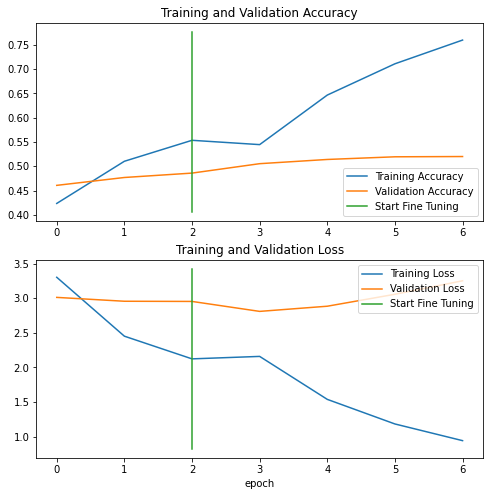

In [ ]:
compare_historys(original_history=history_3, 
                 new_history=history_fine_10_model_3, 
                 initial_epochs=3)